# Explore data and feasibility of approach

![screenshot fo the annotator tool](/media/annotator.png)

We had asked our clients and in-house experts to annotate sentences using a rigorous guideline. The aim is to decide on which sentences they would like to see in a summary for a paper.

The results are in JSON format, each annotator has a separate file. Let's load them.

In [1]:
from pathlib import Path
import json

annotations = []
for p in Path("data").glob("*.json"):
    with open(p, encoding="utf-8") as f:
        print(p)
        annotations.append(json.load(f))

evaluations = {
    sentence: [
        annotation[sentence] for annotation in annotations if sentence in annotation
    ]
    for sentence in {
        sentence for annotation in annotations for sentence in annotation.keys()
    }
}

X = [s for s in evaluations.keys()]
y = [int(sum(e) > 0) for e in evaluations.values()]

data/evaluation-experiment-2-stage #1-sa6a0y.json
data/evaluation-experiment-2-stage #1-2m6dmb.json


Save the compiled and processed data for later use using LargeFileS3.

In [2]:
from great_ai.large_file import LargeFileS3
import json

LargeFileS3.configure_credentials_from_file("config.ini")

with LargeFileS3("summary-train-dataset-small", "w", encoding="utf-8") as f:
    json.dump((X, y), f)

Copying file for summary-train-dataset-small-0
Compressing summary-train-dataset-small-0
Uploading summary-train-dataset-small-0 to S3 as summary-train-dataset-small/0
Uploading summary-train-dataset-small-0.tar.gz 0.04/0.04 MB (100.0%)


Filter out sentences which don't have enough annotations.

In [3]:
y1 = [e[0] for e in evaluations.values() if len(e) == 2]
y2 = [e[1] for e in evaluations.values() if len(e) == 2]

Calculate [Cohen's kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa).

It's a bit low but the task itself is pretty subjective so it's not all that surprising.

In [4]:
import sklearn.metrics

sklearn.metrics.cohen_kappa_score(y1, y2)

0.3546448712421808

Can we train anything on this data?

Let's try with a trivial SVM.

In [5]:
X = [s for s in evaluations.keys()]
y = [int(sum(e) > 0) for e in evaluations.values()]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score


model = Pipeline(
    steps=[
        ("vectorizer", TfidfVectorizer(sublinear_tf=True, min_df=3, max_df=0.3)),
        ("classifier", LinearSVC()),
    ]
)  # baseline model

cross_val_score(model, X, y, cv=5)

array([0.79, 0.75, 0.77, 0.69, 0.77])

The cross-validation shows promising accuracies. But accuracy isn't everything, therefore, we should investigate the accuracy metrics.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.3, min_df=3, sublinear_tf=True)),
                ('classifier', LinearSVC())])

              precision    recall  f1-score   support

       False       0.78      0.78      0.78        51
        True       0.78      0.78      0.78        49

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



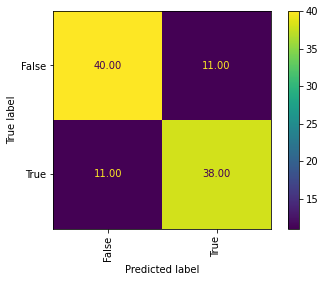

In [8]:
y_predicted = model.predict(X_test)
print(
    sklearn.metrics.classification_report(
        [y > 0 for y in y_test], [y > 0 for y in y_predicted]
    )
)
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    [y > 0 for y in y_test],
    [y > 0 for y in y_predicted],
    xticks_rotation="vertical",
    values_format=".2f",
)
None

We get an F1-score of 0.78 without any hyperparameter-optimisation; this task may be feasible to solve with AI.

Next: [Part 2](/examples/scibert/train)